In [1]:
from visualization.show_bbox import show_two_bounding_boxes

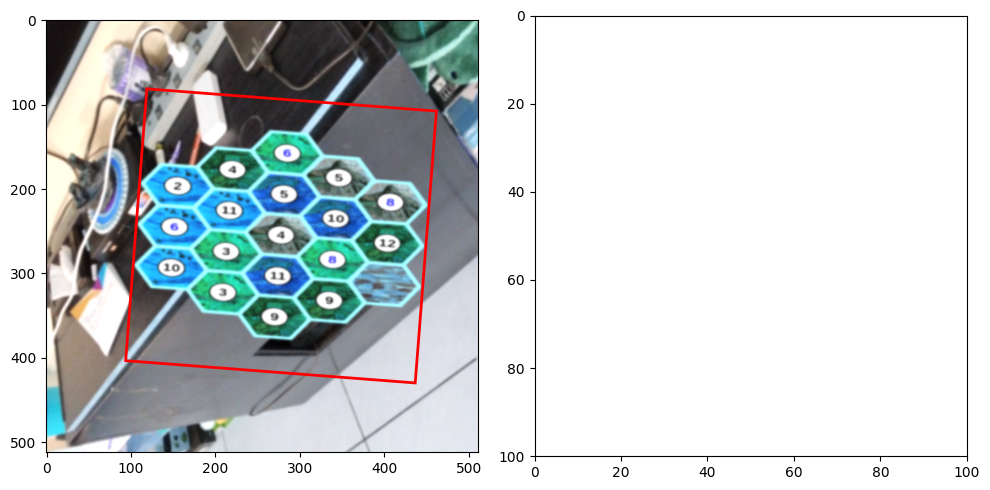

In [17]:
import cv2 
import json 
import os 

with open('data/full/perspective_distorted_boards/bbox_coordinates.json', 'r') as f:
    data = json.load(f)

img_name = "canvas_image_4.png"
bbox = data[img_name]

show_two_bounding_boxes(bbox, bbox, cv2.imread(f"data/full/perspective_distorted_boards/{img_name}"))